In [2]:
%load_ext autoreload
%autoreload 2

In [43]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization, Conv1D, AvgPool1D, Flatten, MaxPool1D, Embedding
from keras.callbacks import EarlyStopping
from keras.regularizers import L1L2, L2, L1
from sklearn.model_selection import StratifiedKFold
import keras
from keras import backend as K

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

### load data

In [3]:
X = np.load('data/abide/postprocessed_timeseries.npy')
Xcorr = np.load('data/abide/postprocessed_corrmats.npy')

In [4]:
# auxiliary inputs
df = pd.read_csv('data/abide/postprocessed_metadata.csv')
age_and_sex_df_normed = (df[['AGE_AT_SCAN', 'SEX']] - [15, 1.5]) / [10, 1]
offline_train = np.array(age_and_sex_df_normed)

In [5]:
# labels
Y = np.array(df['DX_GROUP'] - 1)

In [6]:
# map correlation values to region-pair names
regiondf = pd.read_csv('data/CC200_ROI_labels.csv')
connections = []
multi_index = np.argwhere(np.triu(np.ones([len(regiondf)]*2), k=1))
for idx in multi_index:
    r1, r2 = regiondf.loc[[idx[0], idx[1]], "AAL"].values
    connections.append(r1 + "<->" + r2)
df_Xcorr = pd.DataFrame(data=Xcorr, columns=connections)

### inspect shapes

In [7]:
Y.shape

(741,)

In [8]:
X.shape

(741, 295, 200)

In [9]:
Xcorr.shape

(741, 19900)

In [10]:
offline_train.shape

(741, 2)

In [11]:
print("baseline accuracy of dummy model: ", sum(Y) / len(Y))

baseline accuracy of dummy model:  0.5560053981106613


### model params

In [189]:
class ModelSettings:
    val_size = 0.1
    hidden_dim = 64
    optimizer = keras.optimizers.Adam()
    batch_size = 32
    epochs = 10 # 10 for CNN/LSTM, 200 for linear, 30 for cnn
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    loss = 'binary_crossentropy'
    metrics = ['AUC']
    final_activation = 'sigmoid'

### define cross validation + aggregation function

In [98]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

def train_model(X, Y, pipeline, model_setup_func, n_fold=10):
    classes=np.unique(Y)
    class_weights = class_weight.compute_class_weight(
        'balanced', classes=classes, y=Y
    )
    class_weights = dict(zip(classes, class_weights))
    
    if n_fold:
        # define 10-fold cross validation test harness
        my_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
        cvscores = []
        for train, test in my_kfold.split(np.zeros(Y.size), Y):
            # log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            
            # handle multiple X's / pipelines
            if pipeline is None:
                x_train = X[train]
                x_test = X[test]
            elif isinstance(X, tuple) and isinstance(pipeline, tuple):
                x_train = np.concatenate(
                    [pipe_i.fit_transform(X_i[train]) for X_i, pipe_i in zip(X, pipeline)],
                    axis=1
                )
                x_test = np.concatenate(
                    [pipe_i.transform(X_i[test]) for X_i, pipe_i in zip(X, pipeline)],
                    axis=1
                )
            else:
                x_train = pipeline.fit_transform(X[train])
                x_test = pipeline.transform(X[test])

            model = model_setup_func(x_train.shape)
            model.fit(x_train, Y[train], epochs=ModelSettings.epochs, batch_size=ModelSettings.batch_size,
                      verbose=0, class_weight=class_weights) # , callbacks=[tensorboard_callback])
            scores = model.evaluate(x_test, Y[test], verbose=0)
            print(model.metrics_names[1], scores[1])
            cvscores.append(scores[1])
    else:
        x_train = pipeline.fit_transform(X) if pipeline is not None else X
        model = model_setup_func(x_train.shape)
        print(model.summary())
        model.fit(x_train, Y, epochs=ModelSettings.epochs, batch_size=ModelSettings.batch_size, class_weight=class_weights,
                  validation_split=ModelSettings.val_size, callbacks=[ModelSettings.early_stop])
        cvscores=None
    return model, cvscores

### linear model pipelines in sklearn

In [14]:
lasso_pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('model', LogisticRegression(solver='saga', penalty='l1', class_weight="balanced", max_iter=500))
])

ridge_pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('decompose', PCA(n_components=200)),
    ('model', RidgeClassifier(class_weight="balanced"))
])

#### lasso

In [ ]:
grid_search = GridSearchCV(
    estimator=lasso_pipe,
    param_grid={'model__C': (1, 0.1, 0.01)},
    scoring='roc_auc',
    cv=10,
    n_jobs=-1
)
grid_search = grid_search.fit(Xcorr, Y)
model = grid_search.best_estimator_['model']
coefs = model.coef_.ravel()

In [16]:
print(sum(np.abs(coefs) > 0), "non-zero coeffs in the lasso model")
print("Best roc AUC:", grid_search.best_score_)
grid_search.best_estimator_

1350 non-zero coeffs in the lasso model
Best roc AUC: 0.724795978073417


Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=500, penalty='l1',
                                    solver='saga'))])

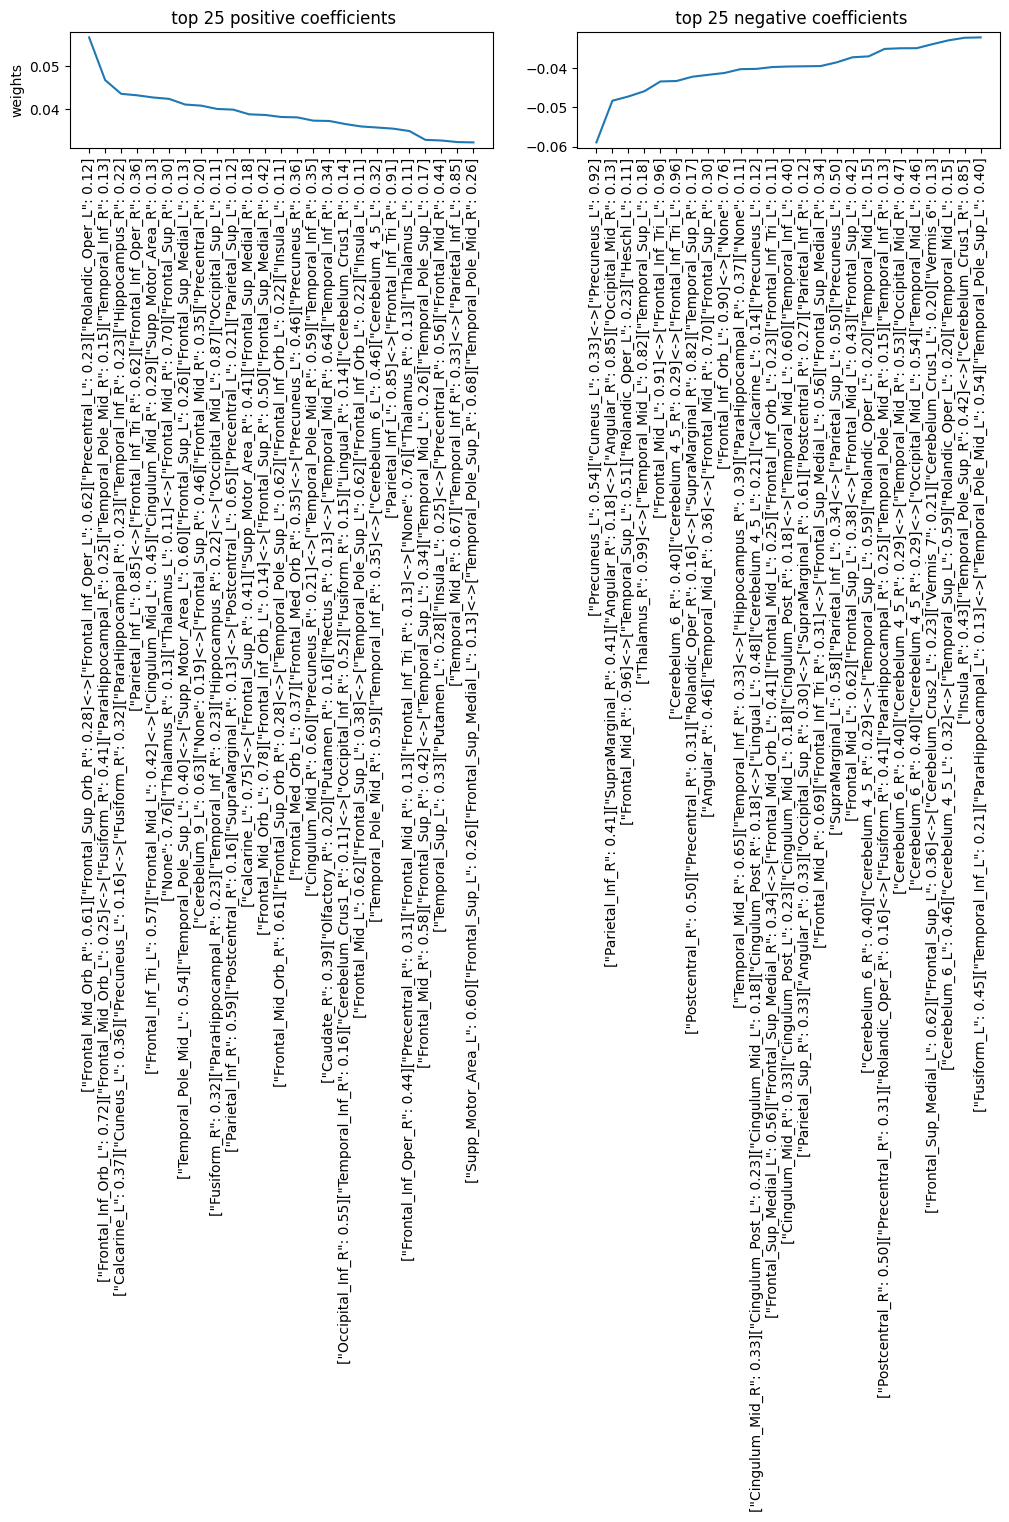

In [17]:
def plot_both_top_k(coefs, k, title_prefix=""):
    fig, ax = plt.subplots(ncols=2, figsize=(12,1.5))
    top_pos_k = np.argsort(coefs)[-1:-k-1:-1]
    top_neg_k = np.argsort(-coefs)[-1:-k-1:-1]
    ax[0].plot(coefs[top_pos_k])
    ax[0].set_title(f"{title_prefix} top {k} positive coefficients")
    ax[0].set_xticks(ticks=np.arange(k), labels=df_Xcorr.columns[top_pos_k], rotation=90)
    ax[1].plot(coefs[top_neg_k])
    ax[1].set_title(f"{title_prefix} top {k} negative coefficients")
    ax[1].set_xticks(ticks=np.arange(k), labels=df_Xcorr.columns[top_neg_k], rotation=90)
    ax[0].set_ylabel("weights")
    plt.show()

plot_both_top_k(coefs, 25)

#### PCA 200 components + ridge

In [20]:
grid_search2 = GridSearchCV(
    estimator=ridge_pipe,
    param_grid={'model__alpha': (10, 100, 1000)},
    scoring='roc_auc',
    cv=10,
    n_jobs=-1
)
grid_search2 = grid_search2.fit(Xcorr, Y)
pca_model = grid_search2.best_estimator_['model']
pca_coefs = pca_model.coef_.ravel()
print("Best roc AUC:", grid_search2.best_score_)
grid_search2.best_estimator_

Best roc AUC: 0.7172015780628586


Pipeline(steps=[('scalar', StandardScaler()),
                ('decompose', PCA(n_components=200)),
                ('model', RidgeClassifier(alpha=100, class_weight='balanced'))])

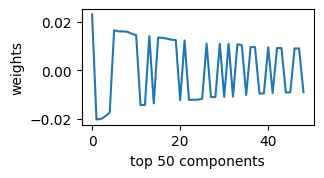

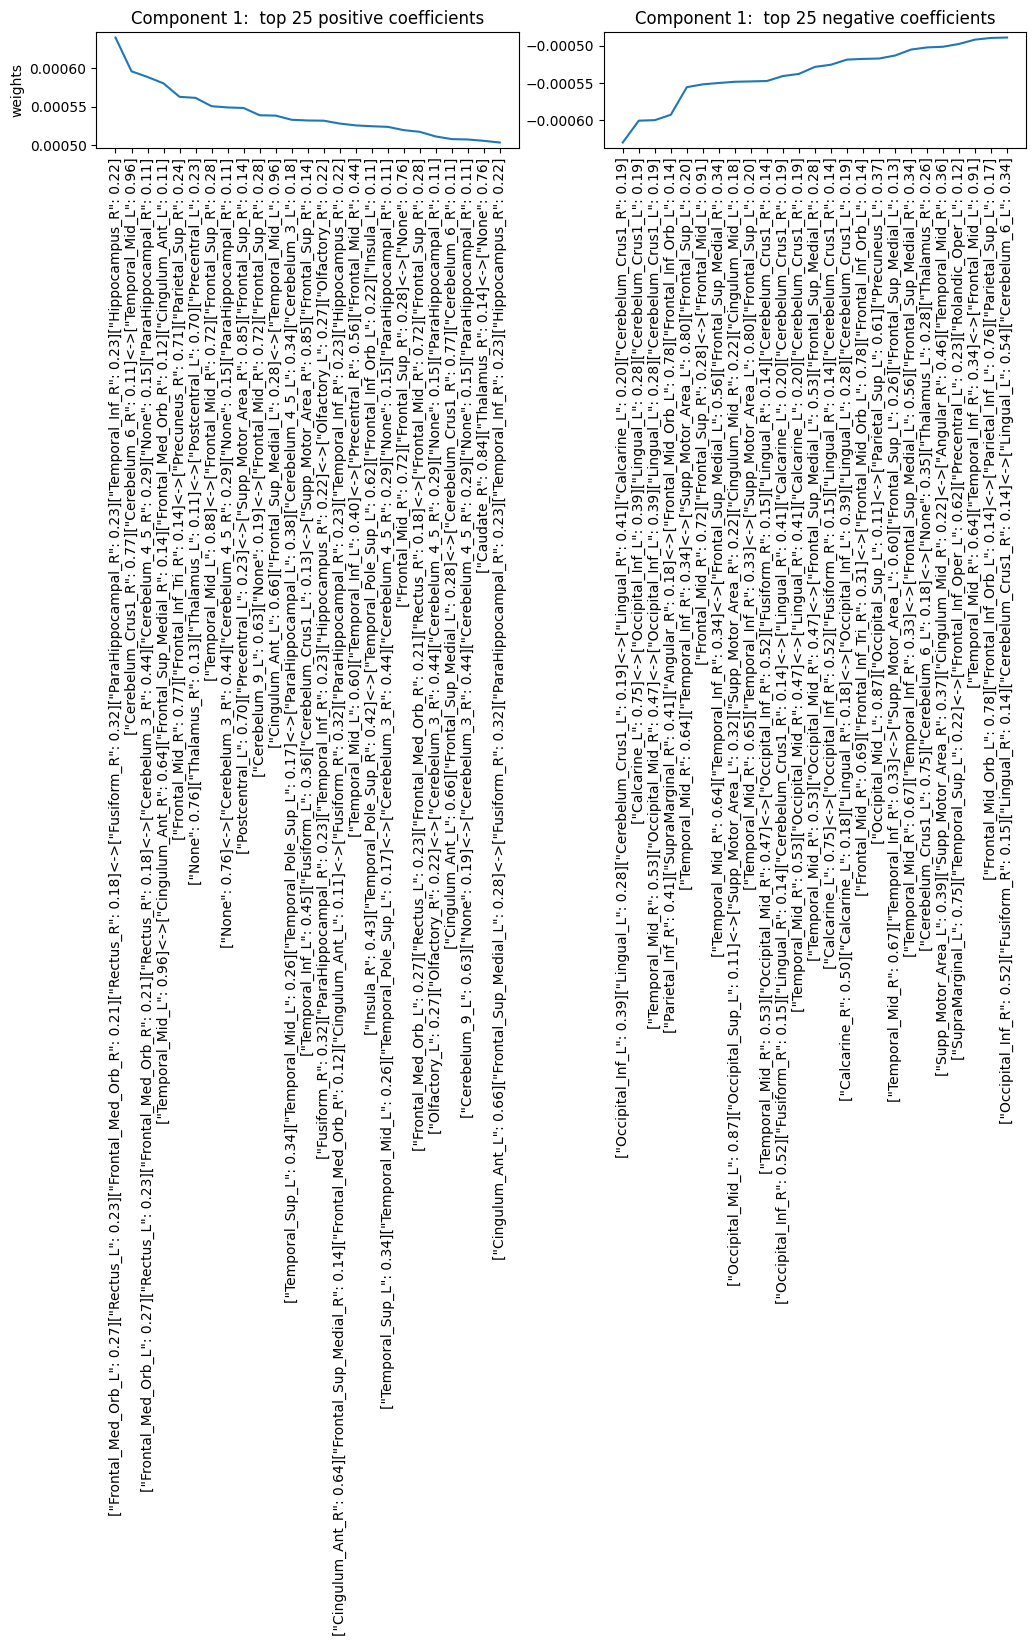

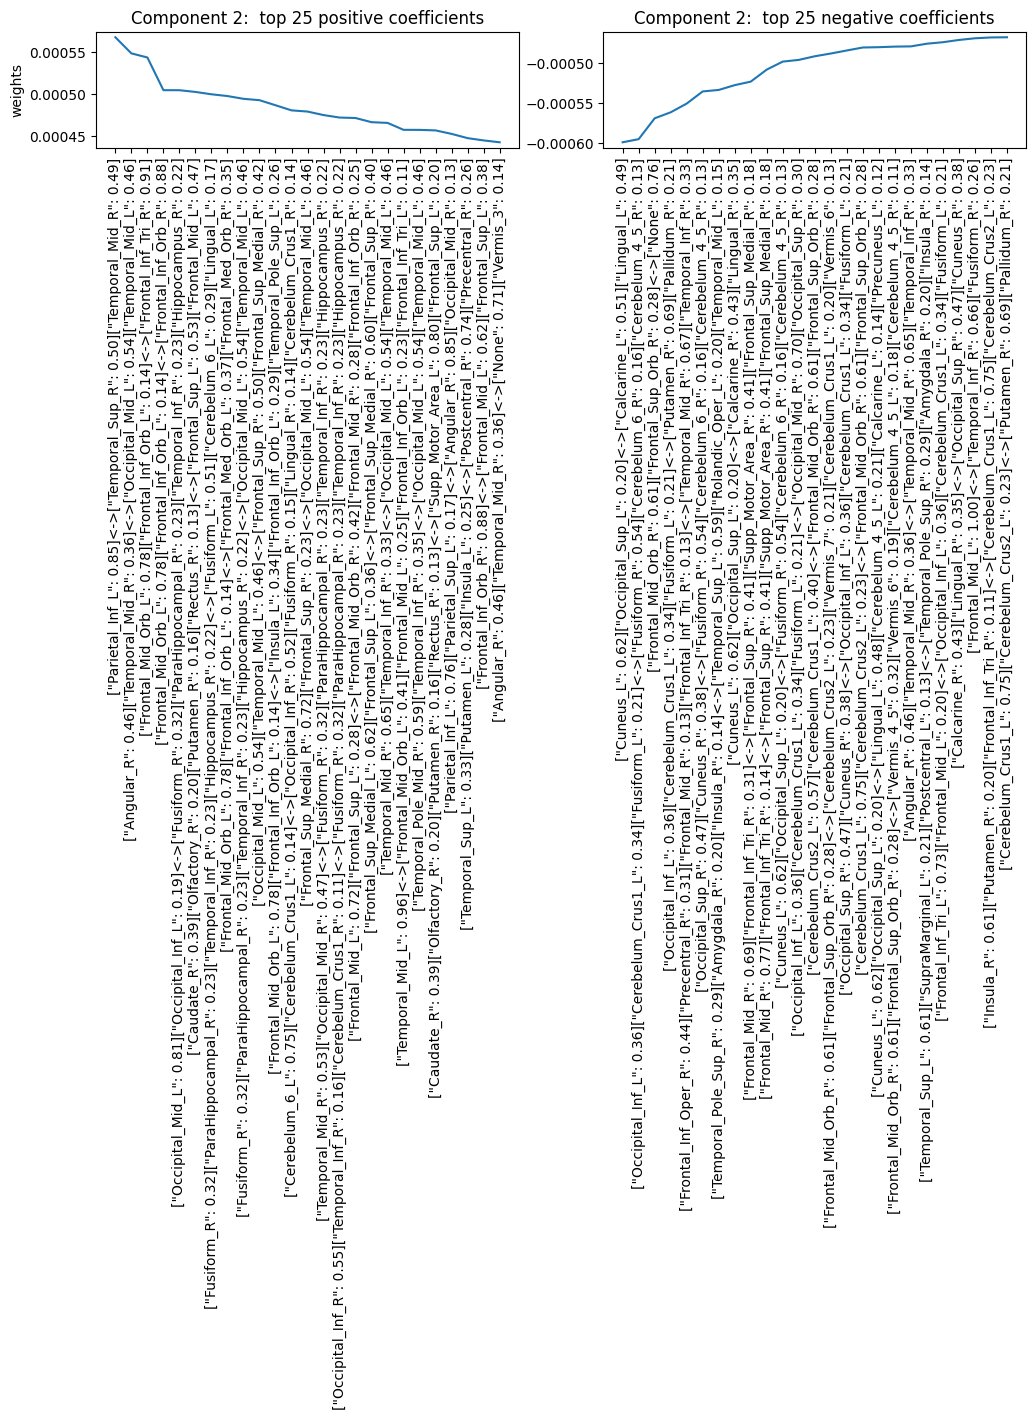

In [39]:
sorted_k = np.argsort(np.abs(pca_coefs))
plt.figure(figsize=(3,1.5))
plt.plot(pca_coefs[sorted_k[-1:-50:-1]])
plt.xlabel("top 50 components")
plt.ylabel("weights")
plt.show()

# multiply the pca loadings by the coeff from the LR, so that the sign is meaningful
top_2_comps = grid_search2.best_estimator_["decompose"].components_[sorted_k[-1:-3:-1]]
for c, comp in enumerate(top_2_comps):
    loadings_weighted_by_lin_coef = comp * pca_coefs[sorted_k[-(c+1)]]
    plot_both_top_k(loadings_weighted_by_lin_coef, 25, title_prefix=f"Component {c+1}: ")

### define linear + mlp models in keras

In [203]:
def setup_linear(input_shape):
    K.clear_session()
    model = Sequential()
    model.add(Dense(1, kernel_regularizer=L2(1.0), input_shape=input_shape[1:], activation=ModelSettings.final_activation))
    model.compile(loss=ModelSettings.loss, optimizer=ModelSettings.optimizer, metrics=ModelSettings.metrics)
    return model

def setup_mlp(input_shape):
    K.clear_session()
    model = Sequential()
    model.add(Dense(64, kernel_regularizer=L2(0.01), input_shape=input_shape[1:], activation="relu"))
    model.add(Dense(1, kernel_regularizer=L2(1.0), activation=ModelSettings.final_activation))
    model.compile(loss=ModelSettings.loss, optimizer=ModelSettings.optimizer, metrics=ModelSettings.metrics)
    return model

pca_pipe = Pipeline([
    ('scalar1', StandardScaler()),
    ('decompose', PCA(n_components=200)),
    ('scalar2', StandardScaler()),
])

#### PCA 200 components + ridge

In [ ]:
model_lin, cvscores_lin = train_model(Xcorr, Y, pca_pipe, setup_linear, n_fold=10)

In [211]:
print(np.mean(cvscores_lin), "+/-", np.std(cvscores_lin))

0.7154726028442383 +/- 0.05745661439151005


#### predictive validity of age and sex

In [ ]:
_, cvscores_as = train_model(offline_train, Y, StandardScaler(), setup_linear, n_fold=10)

In [179]:
print(np.mean(cvscores_as), "+/-", np.std(cvscores_as))

0.5352204829454422 +/- 0.049786023042083696


#### PCA 200 components + mlp

In [ ]:
_, cvscores_mlp = train_model(Xcorr, Y, pca_pipe, setup_mlp, n_fold=10)

In [205]:
print(np.mean(cvscores_mlp), "+/-", np.std(cvscores_mlp))

0.7119981110095978 +/- 0.05017904428669927


#### PCA 200 components + age&sex + mlp

In [ ]:
model_mlp, cvscores_mlp = train_model((Xcorr, offline_train), Y, (pca_pipe, StandardScaler()), setup_mlp, n_fold=10)

In [209]:
print(np.mean(cvscores_mlp), "+/-", np.std(cvscores_mlp))

0.7177033245563507 +/- 0.04991057682949799


### define LSTM setup with timeseries

In [121]:
def setup_lstm(input_shape):
    K.clear_session()
    model = Sequential()
    reg = L2(0.001)
    model.add(keras.layers.Masking(mask_value=0., input_shape=input_shape[1:]))
    model.add(GRU(ModelSettings.hidden_dim, dropout=0.5, recurrent_dropout=0.5, 
                   kernel_regularizer=reg, recurrent_regularizer=reg, bias_regularizer=reg))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=reg, activation=ModelSettings.final_activation))
    model.compile(loss=ModelSettings.loss, optimizer=ModelSettings.optimizer, metrics=ModelSettings.metrics)
    return model

### LSTM / GRU with masking layer

In [122]:
model_lstm, cvscores_lstm = train_model(X, Y, None, setup_lstm, n_fold=10)

auc 0.4426406919956207
auc 0.5831485390663147
auc 0.4985218048095703
auc 0.540280818939209
auc 0.48854395747184753
auc 0.5188469886779785
auc 0.48706579208374023
auc 0.4475240111351013
auc 0.5484108924865723
auc 0.508556604385376


In [194]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 295, 200)          0         
                                                                 
 gru (GRU)                   (None, 64)                51072     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 51,137
Trainable params: 51,137
Non-trainable params: 0
_________________________________________________________________


In [123]:
print(np.mean(cvscores_lstm), "+/-", np.std(cvscores_lstm))

0.506354010105133 +/- 0.04153199703750798


### CNN with hyperalignment layer

N.B. this will be difficult because of so many zeros, probably better to truncate sequences to min length

In [200]:
def down(in_tensor, num_filters, ks=3, padding="same"):
    cnn_layer = Conv1D(filters=num_filters, kernel_size=ks, activation="relu", padding=padding)(in_tensor)
    out_tensor = keras.layers.MaxPooling1D(pool_size=2)(cnn_layer)
    num_filters_next = num_filters * 2
    return out_tensor, num_filters_next

def setup_cnn(input_shape):
    inputs = keras.layers.Input(input_shape[1:])
    hyperalignment_layer = Conv1D(128, 1, kernel_regularizer=L2(0.0001))(inputs)
    cnn_layer, num_filters = down(hyperalignment_layer, 16)
    cnn_layer, num_filters = down(cnn_layer, num_filters)
    cnn_layer, num_filters = down(cnn_layer, num_filters)
    cnn_layer, num_filters = down(cnn_layer, num_filters // 2 )
    flattened = Flatten()(cnn_layer)
    dense = Dense(32, kernel_regularizer=L2(0.001), activation="relu")(flattened)
    output = Dense(1, kernel_regularizer=L2(0.1), activation=ModelSettings.final_activation)(dense)
    model = keras.models.Model(inputs=inputs, outputs=output)
    model.compile(loss=ModelSettings.loss, optimizer=ModelSettings.optimizer, metrics=ModelSettings.metrics)
    return model

In [191]:
model, cvscores = train_model(X, Y, None, setup_cnn, n_fold=10)

auc 0.4761905074119568
auc 0.6237989664077759
auc 0.5040650963783264
auc 0.5572800636291504
auc 0.5698447823524475
auc 0.432372510433197
auc 0.5502586960792542
auc 0.5
auc 0.5033259391784668
auc 0.5930059552192688


In [193]:
model.summary()

Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 295, 200)]        0         
                                                                 
 conv1d_238 (Conv1D)         (None, 295, 128)          25728     
                                                                 
 conv1d_239 (Conv1D)         (None, 295, 16)           6160      
                                                                 
 max_pooling1d_196 (MaxPooli  (None, 147, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_240 (Conv1D)         (None, 147, 32)           1568      
                                                                 
 max_pooling1d_197 (MaxPooli  (None, 73, 32)           0         
 ng1D)                                                    

In [192]:
print(np.mean(cvscores), "+/-", np.std(cvscores))

0.5310142517089844 +/- 0.054964211723992774
